# 浙江大学软件学院人工智能夏令营实训开发项目1

# GAN在人脸图像生成中的应用

# 基于无监督控制生成图像语义特征的GAN与Diffusion模型在人脸生成中的应用

---
## 1 项目背景介绍

    随着计算机视觉技术的不断进步，图像生成技术得到了广泛应用。人脸图像生成是计算机视觉和机器学习领域的一个活跃研究方向，具有广泛的应用前景。随着深度学习技术的飞速发展，尤其是生成对抗网络（GAN）的提出，人脸图像生成技术取得了显著的进步。GAN通过对抗性训练的方式，能够生成高质量、逼真的人脸图像，这在图像编辑、娱乐、游戏开发等多个领域展现出巨大的潜力。然而目前大多数基于GAN网络进行图像生成仍然存在许多的问题，比如大多数GAN模型很难够去捕捉到在特定层中具有控制语义属性的特征，从而控制生成图像的语义属性。因此如何改进GAN模型去捕捉到各个层次的语义信息，并生成含有不同语义属性的图像，仍然是一个值得研究的问题。

    近年来，随着深度学习技术的不断发展，基于GAN模型进行人脸图像生成也逐渐成为主流。自从Ian Goodfellow等人于2014年提出GAN以来，该技术已被广泛应用和改进，推动了图像生成技术的发展。但是基础的GAN网络存在训练不稳定和模式崩溃等问题。为了克服这些问题，Alec Radford等人提出的DCGAN（Deep Convolutional GAN）模型，通过引入卷积神经网络结构，显著提高了图像生成的质量和稳定性。Martin Arjovsky等人提出的WGAN（Wasserstein GAN）通过引入Wasserstein距离，改善了训练的稳定性，并有效地缓解了模式崩溃问题。进一步的改进如Ishaan Gulrajani提出的WGAN-GP（WGAN with Gradient Penalty），该模型通过加入梯度惩罚，进一步提升了模型性能。为了生成高分辨率的人脸图像，StyleGAN及其后续版本（StyleGAN2）在此基础上引入了风格混合技术和自适应归一化层，使得生成的人脸图像更加细腻且具有丰富的细节。虽然这些GAN模型能够生成高质量的人脸图像，但是如何控制生成图像的语义属性仍然是一个挑战。

    在本次项目中，我将会提出一种利用无监督地学习方式，从不同生成层中挖掘可解释和可控维度的特征的GAN模型。具体来说，本项目所设计的GAN模型可以去自动挖掘出每一生成层对应的的一组语义特征信息，从而控制生成图像的语义属性。此外，我还采用了最近较为流行的Diffusion模型进行相关的人脸生成任务，进而比较这两种模型的生成效果。

在这个项目中，我们将会探索以下任务：

- 如何进行图像生成

- 如何控制生成图像的语义特征

- 如何判定生成图像的优劣程度
    
根据上述问题，我将本项目的核心亮点总结如下：

- 采用了一种可以**无监督学习**方式控制生成图像**语义属性**的GAN网络模型

- 额外采用**Diffusion**模型进行人脸生成，并进行分析生成的效果

- 通过计算生成图像和真实图像在高维特征空间中的分布差异（**FID指标**），来判定生成模型的效果
    
我将会采用数据可视化，神经网络模型搭建，模型评估指标等步骤来解答上述问题和体现亮点。

---
## 2 基于GAN模型的人脸生成

---
### 2.1 导入相关的包
导入本项目所需要的资源包


In [1]:
import os
from IPython.display import SVG
from PIL import Image
from torch import nn
import copy
import pandas as pd
import shutil
from tqdm import tqdm
from datetime import datetime
import torchvision
from functools import partial
from torchvision import models
import random
import math
import torch.nn.functional as F
import numpy as np
from scipy import linalg
from typing import Optional
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")

Duplicate key in file PosixPath('/usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 799 ('font.family: sans-serif')
Duplicate key in file PosixPath('/usr/local/lib/python3.9/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 800 ('font.sans-serif: SimHei')


---
### 2.2 数据集处理

#### 2.2.1 数据集导入
本项目采用的是CelebA的人脸数据集，该数据集是一个广泛用于计算机视觉研究和应用的面部图像数据集。它包含超过20万张名人面部图像，并附带有40个属性标签，如性别、年龄、发型、眼镜等。可以适用于面部识别、属性预测、图像生成、风格转换等计算机视觉领域的研究。该数据集的获取地址在：[CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)，具体介绍如下：
- CelebA数据集包含202,599张名人面部图像，覆盖了大量不同的个体，提供了一个非常广泛和多样的面部图像集合。
- 数据集被分为训练集、验证集和测试集，分别包含162,770张、19,867张和19,962张图像。这种分割方式有助于模型训练和性能评估。
- 文件列表

    该数据集包含4个csv文件和一个文件夹
    - img_align_celeba文件夹：该文件夹包含所有的名人面部图像，存储用于训练和测试的原始图像数据。文件夹内每张图像以JPEG格式保存，文件名通常是图片编号，如`000001.jpg`。
    - list_attr_celeba.csv：包含每张图像的40个属性标签。提供图像的属性信息，如性别、微笑、眼镜等，方便属性预测任务。
    - list_bbox_celeba.csv：包含每张图像的边界框信息。提供图像中人脸的位置信息，常用于人脸检测和裁剪任务。
    - list_eval_partition.csv：包含图像的划分信息，用于将数据集分成训练集、验证集和测试集。提供图像所属的集合信息，帮助研究人员在模型训练和评估中进行数据划分。
    - list_landmarks_align_celeba.csv：包含每张图像的人脸关键点信息。提供人脸的关键点坐标，常用于人脸对齐和姿态估计任务。
    
但本次项目是做关于人脸图像生成的问题，所以我们只需要img_align_celeba文件夹和list_attr_partition.csv这两个数据。

本项目所有的数据集已导入至文件路径：`datasets/6682b8f40a244fae6ddff5ce-650aa94c001b102e9e91d7a3/`。通过查阅相关的资料，我们测试所用的测试集是从训练数据集中挑选50k张图片。

#### 2.2.2数据集分析

- 分割训练集和测试集, 由于数据集处理已经在本地处理，所以代码如下所示：

```python 
import os
import random
import shutil


source_folder = './dataset/img_align_celeba/img_align_celeba'  
target_folder = './dataset/test'  

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

all_images = os.listdir(source_folder)

for image in all_images:
    source_path = os.path.join(source_folder, image)
    target_path = os.path.join(target_folder, image)
    shutil.copy(source_path, target_path)

print("50,000 images have been randomly selected and copied to the target folder.")
```


- 统计原数据集包含人脸图像的数量

In [2]:
images_folder = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train'
image_count = len([name for name in os.listdir(images_folder) if name.endswith('.jpg')])
print(f'数据集中的图片数量: {image_count}')

数据集中的图片数量: 202599


- 我将会对原人脸数据集进行初步的可视化分析

In [3]:
PIC_DIR = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train/'
IMAGES_COUNT = 101
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.LANCZOS)
    images.append(np.uint8(pic))
#Normalize the images
images = np.array(images) / 255
#print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

100%|██████████| 101/101 [00:00<00:00, 116.80it/s]


- 训练集，测试集的大小

In [4]:
train_folder = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train/'
test_folder = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/test'
image_count_train = len([name for name in os.listdir(train_folder) if name.endswith('.jpg')])
print(f'训练集的图片数量: {image_count_train}')
image_count_test = len([name for name in os.listdir(test_folder) if name.endswith('.jpg')])
print(f'测试集的图片数量: {image_count_test}')
data1 = pd.Series({'训练集':image_count_train/(image_count_train+image_count_test), '测试集':image_count_test/(image_count_train+image_count_test)})
#将序列的名称设置为空字符，否则绘制的饼图左边会出现None这样的字眼
data1.name = ''
#控制饼图为正圆
plt.axes(aspect = 'equal')
#防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
#plot方法对序列进行绘图
data1.plot(kind = 'pie',  #选择图形类型
           autopct = '%.2f%%',  #饼图中添加数值标签
           radius = 1,  #设置饼图半径
           startangle = 180,  #设置饼图的初始角度
           counterclock = False,  #将饼图的顺序设置为顺时针方向
           title = '训练集和测试集分布',  #为饼图添加标题
           wedgeprops = {'linewidth':1.5, 'edgecolor':'green'},  #设置饼图内外边界的属性值
           textprops = {'fontsize':10, 'color':'black'},  #设置文本标签的属性值
           )
#显示图形
plt.show()

训练集的图片数量: 202599
测试集的图片数量: 50000


- 人脸图像中，各个属性的分布情况统计

<Figure size 1944x1440 with 0 Axes>

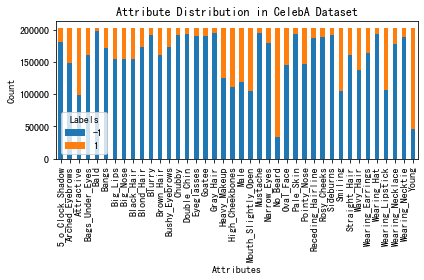

In [5]:
# 去掉image_id列，统计每个属性的正负样本数量
data = pd.read_csv("../datasets/669211127c9055c036ed958b-650aa94c001b102e9e91d7a3/list_attr_celeba.csv")
attributes = data.drop(columns=['image_id'])
attribute_counts = attributes.apply(lambda x: x.value_counts()).fillna(0).astype(int)
# 创建条状图
plt.figure(figsize=(27, 20))
attribute_counts.T.plot(kind='bar', stacked=True)
plt.title('Attribute Distribution in CelebA Dataset')
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.legend(['-1', '1'], title='Labels')
plt.tight_layout()
plt.show()

从中，我们可以发现“无胡子”的人脸图像占比最多，“秃头”的图像占比最少。因此，我们之后产生的图像中，秃头的生成图像占比较少，无胡子的生成图像占比较多。

- 根据对应的图片文件路径构建数据集

In [6]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


def infinite_loader(data_loader):
    while True:
        for batch in data_loader:
            yield batch


class Dataset:
    def __init__(self, root, transform=None):
        self.root = root
        self.imgs = []
        for dir, _, fnames in sorted(os.walk(root, followlinks=True)):
            for fname in sorted(fnames):
                if fname.lower().endswith(IMG_EXTENSIONS):
                    self.imgs.append(os.path.join(dir, fname))

        self.transform = transform if transform is not None else lambda x: x

    def __getitem__(self, index):
        with open(self.imgs[index], 'rb') as f:
            img = Image.open(f)
            return self.transform(img.convert('RGB'))

    def __len__(self):
        return len(self.imgs)
    def get_subset(self, indices):
        subset = Dataset(self.root, self.transform)
        subset.imgs = [self.imgs[i] for i in indices]
        return subset

#### 2.2.3 数据预处理、可视化

- 数据增强（随机调整亮度、随机饱和度调整、随机对比度调整、随机平移和随机遮挡），通过数据增强的操作，可以增强模型的鲁棒性，提高模型的生成效果

- 定义展示图片的函数

In [7]:
def show(original_image, augmented_image):
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    
    axs[0].imshow(original_image)
    axs[0].set_title("original image")
    axs[0].axis('off')
    
    axs[1].imshow(augmented_image)
    axs[1].set_title("augment image")
    axs[1].axis('off')
    
    plt.show()

- 定义相关图像增强的函数

In [8]:
def DiffAugment(policy='color,translation,cutout', p=0.6):

    def augment(x, policy, p):
        if policy:
            for op in policy.split(','):
                for f in AUGMENT_FNS[op]:
                    if random.random() < p:
                        x = f(x)
            x = x.contiguous()
        return x

    return partial(augment, policy=policy, p=p)


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y]
    x = x.permute(0, 3, 1, 2).contiguous()
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(
        0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device
    )
    offset_y = torch.randint(
        0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device
    )
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

- 展示图片展示的示例

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


亮度、饱和度、对比度随机增强


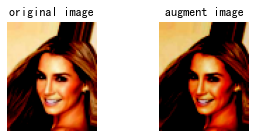

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


平移随机改变


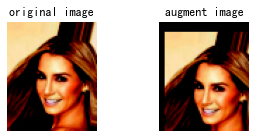

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


遮挡随机增强


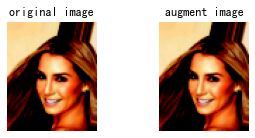

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


随机增强


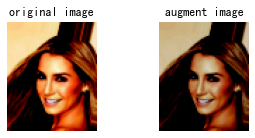

经过数据增强后的图片信息： [[[ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  ...
  [ 0.24872145  0.0862404  -0.1737293 ]
  [ 0.7029941   0.6055055   0.4213603 ]
  [ 0.81410146  0.7220289   0.6407884 ]]

 [[ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  ...
  [ 0.34769326  0.19062828 -0.04767731]
  [ 0.7532891   0.65580046  0.4933194 ]
  [ 0.81571954  0.729063    0.6478225 ]]

 [[ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  [ 0.7882124   0.66905963  0.46866634]
  ...
  [ 0.45774442  0.31692752  0.10028611]
  [ 0.78030187  0.70447737  0.5744925 ]
  [ 0.8024604   0.7266359   0.6399793 ]]

 ...

 [[ 0.18505497 -0.16157131 -0.426957  ]
  [ 0.0855213  -0.2773531  -0.49399447]
  [-0.28989312 -0.64735144 -0.81524855]
  ...
  [-0.47763398 -0.8080121  -0.9217489 ]
  [-0.44221625 -0.7617624  -0.87008303]
  [-0.39192128 -0.7006353  -0.

In [9]:
ColorAugment = DiffAugment('color')
TranslationAugment = DiffAugment('translation')
CutoutAugment = DiffAugment('cutout')
Augment = DiffAugment()
fig = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train/000001.jpg'
image = Image.open(fig)
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
])
tensor_image = transform(image)
tensor_image = tensor_image.unsqueeze(0)
ColorImage = ColorAugment(tensor_image).squeeze(0)
TranslationImage = TranslationAugment(tensor_image).squeeze(0)
CutoutImage = CutoutAugment(tensor_image).squeeze(0)
AugmentImage = Augment(tensor_image).squeeze(0)
original_image = tensor_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
augmented_color_image = ColorImage.permute(1, 2, 0).cpu().detach().numpy()
augmented_translation_image = TranslationImage.permute(1, 2, 0).cpu().detach().numpy()
augmented_cutout_image = CutoutImage.permute(1, 2, 0).cpu().detach().numpy()
augmentImage =AugmentImage.permute(1, 2, 0).cpu().detach().numpy()
print("亮度、饱和度、对比度随机增强")
show(original_image,augmented_color_image)
print("平移随机改变")
show(original_image,augmented_translation_image)
print("遮挡随机增强")
show(original_image,augmented_cutout_image)
print("随机增强")
show(original_image,augmentImage)
print("经过数据增强后的图片信息：", augmentImage)

经过分析和可视化的研究，本次选用的数据集数量较多，而为了更好增强模型的生成图片的效果，我们额外采用了数据增强的操作（包括调整亮度，饱和度，平移，裁剪）。

---
### 2.3 模型训练步骤

#### 2.3.1 模型构建
本模型为输入，输出为512维度的噪声，输出为($3 \times 64 \times 64$)的生成图像，这里将GAN作为人脸图像生成的基准模型。我们需要设计出一个可以捕捉到生成层中**各个层次的语义特征**的GAN网络。

所提出的模型框架主要还是基于GAN网络，所以该模型主要由捕捉各个层次语义信息的生成器和鉴别器这两个部分组成。针对于GAN网络的生成器和鉴别器的介绍，具体如下：

- 生成器的任务是从随机噪声中生成逼真的数据。它的输入通常是一些随机噪声（正态分布中采样的向量），输出是与真实数据分布尽可能相似的伪造数据。

- 鉴别器的任务是区分真实数据和生成器生成的伪造数据。它的输入是数据样本（可能是真实数据或伪造数据），输出是一个标量值，表示该数据为真实数据的概率。

而针对于本次提出的模型，我们在生成器部分做出了相关的改进，我们在生成器中的每一生成层中嵌入一个具有正交基的线性子空间用来捕获各个语义特征。具体的步骤如下：

1. 首先，通过生成性对抗性训练，生成器试图捕捉数据分布的主要变化，这些主要变化按照其抽象程度分别在不同的生成层中表示。

2. 接着，借助子空间模型，将特定层主要变化进一步正交分离为不同的基向量。

3. 最后，每个基向量发现一个控制属性或与其生成层的语义相对应的可解释变量。

具体的生成器的流程图如下图所示：
<div align="center">
    <img src="./others/flowchart.png" alt="图片title" title="图片title" >
</div>

模型相关的基本函数
- get_activation()：根据函数参数返回对应的激活函数层(包含`RELU`激活函数和`LRELU`激活函数)。

- get_normalization()：根据参数返回对应的归一化层(包含`InstanceNorm2d`、`BatchNorm2d`,`GroupNorm`,`LayerNorm`)。

In [10]:
def get_activation(activation: str = "lrelu"):
    actv_layers = {
        "relu":  nn.ReLU,
        "lrelu": partial(nn.LeakyReLU, 0.2),
    }
    assert activation in actv_layers, f"activation [{activation}] not implemented"
    return actv_layers[activation]


def get_normalization(normalization: str = "batch_norm"):
    norm_layers = {
        "instance_norm": nn.InstanceNorm2d,
        "batch_norm":    nn.BatchNorm2d,
        "group_norm":    partial(nn.GroupNorm, num_groups=8),
        "layer_norm":    partial(nn.GroupNorm, num_groups=1),
    }
    assert normalization in norm_layers, f"normalization [{normalization}] not implemented"
    return norm_layers[normalization]

Moudle
- ConvLayer: 一个封装的卷积层模块，它可以动态配置卷积层、归一化层和激活函数，并且支持标准卷积和反卷积。

- SubspaceLayer: 用于子空间的转换，实现了一个线性变化，将一个向量从低维度到高维度转化。

- EigenBlock: 结合了子空间和卷积的操作，它的主要功能是将输入特征映射到一个子空间，然后进行卷积操作，以提取特征并降低维度。

In [11]:
class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = 1,
        padding_mode: str = "zeros",
        groups: int = 1,
        bias: bool = True,
        transposed: bool = False,
        normalization: Optional[str] = None,
        activation: Optional[str] = "lrelu",
        pre_activate: bool = False,
    ):
        if transposed:
            conv = partial(nn.ConvTranspose2d, output_padding=stride-1)
            padding_mode = "zeros"
        else:
            conv = nn.Conv2d
        layers = [
            conv(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                padding_mode=padding_mode,
                groups=groups,
                bias=bias,
            )
        ]

        norm_actv = []
        if normalization is not None:
            norm_actv.append(
                get_normalization(normalization)(
                    num_channels=in_channels if pre_activate else out_channels
                )
            )
        if activation is not None:
            norm_actv.append(
                get_activation(activation)(inplace=True)
            )

        if pre_activate:
            layers = norm_actv + layers
        else:
            layers = layers + norm_actv

        super().__init__(
            *layers
        )


class SubspaceLayer(nn.Module):
    def __init__(
        self,
        dim: int,
        n_basis: int,
    ):
        super().__init__()

        self.U = nn.Parameter(torch.empty(n_basis, dim))
        nn.init.orthogonal_(self.U)
        self.L = nn.Parameter(torch.FloatTensor([3 * i for i in range(n_basis, 0, -1)]))
        self.mu = nn.Parameter(torch.zeros(dim))

    def forward(self, z):
        return (self.L * z) @ self.U + self.mu


class EigenBlock(nn.Module):
    def __init__(
        self,
        width: int,
        height: int,
        in_channels: int,
        out_channels: int,
        n_basis: int,
    ):
        super().__init__()

        self.projection = SubspaceLayer(dim=width*height*in_channels, n_basis=n_basis)
        self.subspace_conv1 = ConvLayer(
            in_channels,
            in_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            transposed=True,
            activation=None,
            normalization=None,
        )
        self.subspace_conv2 = ConvLayer(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            transposed=True,
            activation=None,
            normalization=None,
        )

        self.feature_conv1 = ConvLayer(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=2,
            transposed=True,
            pre_activate=True,
        )
        self.feature_conv2 = ConvLayer(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            transposed=True,
            pre_activate=True,
        )

    def forward(self, z, h):
        phi = self.projection(z).view(h.shape)
        h = self.feature_conv1(h + self.subspace_conv1(phi))
        h = self.feature_conv2(h + self.subspace_conv2(phi))
        return h

生成器模块

提出的GAN模型中的生成器模块通过学习每个层级的“特征向量”（或称为“特征空间”），模型能够理解并独立调整这些属性，提供了对图像的精细控制。而具体实现控制这些特征向量的操作如下所示：

我们假设该生成器中含有$t$层，其中第$i$个生成层中额外包含以下信息：

- 含有一组子空间的标准正交基，我们表示为$U_{i} = [u_{i1}, \ldots, u_{iq}]$，其中$q$表示的是每一个潜向量包含的基准数。这一组子空间的标准正交基主要是用来无监督地捕捉到合成样本的可解释变化的特征维度信息。

- 含有一组对角矩阵，我们表示为$L_{i} = diga(l_{i1}, \ldots, l_{iq})$。而$l_{ij}$主要是用来确定基向量$u_{ij}$的重要性。比如，绝对值较高的$l_{ij}$就表示$u_{ij}$控制着第$i$层中的较大变化；相反，绝对值较低的$l_{ij}$就表示$u_{ij}$控制着第$i$层中的较小变化。我们可以把$L_{i}$看成一种特征选择器。 

- 含有子空间的坐标原点$\mu_i$。 

- 含有一组潜向量，我们将其表示为$z_i = [z_{i1} , \ldots, z_{iq}]^T$，用来采样子空间的坐标。该子空间直接决定第$i$层的变化，具体来说，这$q$的值，分别控制着$q$个不同的特征变化

而对于第$i$层的生成层的整个操作，主要有两个步骤，分别是计算子空间采样的坐标，嵌入额外噪声输入，转置卷积提高特征图分辨率这两个操作，下面进行详细的说明：

- 计算子空间采样的坐标$\phi_i$：利用$z_i$层的向量，计算公式如下所示：
$$
\phi_i = U_iL_iz_i + \mu = \sum_{i=1}^{q}z_{ij}l_{ij}u_{ij} + \mu_i
$$

- 在第一层中通过嵌入一个额外的噪声输入$\epsilon$ ~ $\mathcal{N}(0,1)$用来去捕获子空间中遗漏的其余特征向量，最终得到一组特征图$h_1$。具体的计算公式如下所示：
$$
    h_1 = FC(\epsilon)
$$
其中，FC代表的是全连接层。

- 通过转置卷积传递对应的特征图，通过不断增大特征图的分辨率，最终能够输出合成的样本。具体的计算公式如下所示：
$$
    h_{i+1} = ConvTranspose(h_i + f(\phi_i))
$$
其中，ConvTranspose代表的是转置卷积，f代表的是$1 \times 1$的卷积。

In [12]:
class Generator(nn.Module):
    def __init__(
        self,
        size: int = 256,
        n_basis: int = 6,
        noise_dim: int = 512,
        base_channels: int = 16,
        max_channels: int = 512,
    ):
        super().__init__()

        assert (size & (size-1) == 0) and size != 0, "img size should be a power of 2"

        self.noise_dim = noise_dim
        self.n_basis = n_basis
        self.n_blocks = int(math.log(size, 2)) - 2

        def get_channels(i_block):
            return min(max_channels, base_channels * (2 ** (self.n_blocks - i_block)))

        self.fc = nn.Linear(self.noise_dim, 4 * 4 * get_channels(0))

        self.blocks = nn.ModuleList()
        for i in range(self.n_blocks):
            self.blocks.append(
                EigenBlock(
                    width=4 * (2 ** i),
                    height=4 * (2 ** i),
                    in_channels=get_channels(i),
                    out_channels=get_channels(i+1),
                    n_basis=self.n_basis,
                )
            )

        self.to_rgb = nn.Sequential(
            ConvLayer(base_channels, 3, kernel_size=7, stride=1, padding=3, pre_activate=True),
            nn.Tanh(),
        )

    def sample_latents(self, batch: int, truncation=1.0):
        device = self.get_device()
        es = torch.randn(batch, self.noise_dim, device=device)
        zs = torch.randn(batch, self.n_blocks, self.n_basis, device=device)
        if truncation < 1.0:
            es = torch.zeros_like(es) * (1 - truncation) + es * truncation
            zs = torch.zeros_like(zs) * (1 - truncation) + zs * truncation
        return es, zs

    def sample(self, batch: int, truncation=1.0):
        return self.forward(self.sample_latents(batch, truncation=truncation))

    def forward(self, latents: tuple):
        input, zs = latents

        out = self.fc(input).view(len(input), -1, 4, 4)
        for block, z in zip(self.blocks, zs.permute(1, 0, 2)):
            out = block(z, out)

        return self.to_rgb(out)

    def orthogonal_regularizer(self):
        reg = []
        for layer in self.modules():
            if isinstance(layer, SubspaceLayer):
                UUT = layer.U @ layer.U.t()
                reg.append(
                    ((UUT - torch.eye(UUT.shape[0], device=UUT.device)) ** 2).mean()
                )
        return sum(reg) / len(reg)

    def get_device(self):
        return self.fc.weight.device

鉴别器模块

鉴别器的主要功能是接收输入图像，并判断其是真实图像还是生成图像。本模型采用的鉴别器主要还是利用多个卷积层提取图像特征，最终通过全连接层进行分类。

In [13]:
class Discriminator(nn.Module):
    def __init__(
        self,
        size: int = 256,
        base_channels: int = 16,
        max_channels: int = 512,
    ):
        super().__init__()

        blocks = [
            ConvLayer(3, base_channels, kernel_size=7, stride=1, padding=3),
        ]

        channels = base_channels
        for _ in range(int(math.log(size, 2)) - 2):
            next_channels = min(max_channels, channels * 2)
            blocks += [
                ConvLayer(channels, channels, kernel_size=3, stride=1),
                ConvLayer(channels, next_channels, kernel_size=3, stride=2),
            ]
            channels = next_channels

        blocks.append(
            ConvLayer(channels, channels, kernel_size=3, stride=1)
        )
        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.Linear(4 * 4 * channels, channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(channels, 1)
        )

    def forward(self, input):
        out = self.blocks(input)
        return self.classifier(out.view(len(out), -1))

#### 2.3.2 损失函数

$loss$这里只使用了`hinge loss`，而对于GAN网络而言，它需要设计两个损失函数，其中一个生成器的损失函数，另外一个是鉴别器的损失函数，下面进行具体的分析：

- 鉴别器的损失函数：对于真实样本的损失，具体公式如下：
$$
    Loss_{real} = max(0, 1 - real_{pred})
$$
对于生成样本的损失，具体公式如下所示：
$$
    Loss_{real} = max(0, 1 - real_{pred})
$$
所以对于整个生成器的损失函数，具体表达式子如下所示：
$$
    d_{loss} = \frac{1}{N} \sum_{i=1}^{N} \left( \max(0, 1 - real_{pred}^i) + \max(0, 1 + fake_{pred}^i) \right)
$$
- 生成器的损失函数：具体的生成器的损失函数如下所示：
$$
    g_{loss} = \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - fake_{pred}^i)
$$
而为了引入正则化的效果，我们还会计算生成器模型中权重矩阵的正交性约束，并返回一个正则化惩罚值。将这个正则化惩罚值加入到生成器的总损失中以提高正则化的效果

In [14]:
def hinge_loss():

    def d_loss(real_pred, fake_pred):
        return (
            torch.nn.functional.relu(1 - real_pred).mean()
            + torch.nn.functional.relu(1 + fake_pred).mean()
        )

    def g_loss(fake_pred):
        return torch.nn.functional.relu(1 - fake_pred).mean()

    return d_loss, g_loss


def non_saturating_loss():

    def d_loss(real_pred, fake_pred):
        return (
            torch.nn.functional.softplus(-real_pred).mean()
            + torch.nn.functional.softplus(fake_pred).mean()
        )

    def g_loss(fake_pred):
        return torch.nn.functional.softplus(-fake_pred).mean()

    return d_loss, g_loss


def lsgan_loss():

    def d_loss(real_pred, fake_pred):
        return (
            torch.square((1 - real_pred)**2).mean()
            + torch.square(fake_pred**2).mean()
        )

    def g_loss(fake_pred):
        return torch.square((1 - fake_pred)**2).mean()

    return d_loss, g_loss


def get_adversarial_losses(type="hinge"):

    ADV_LOSSES = {
        "hinge": hinge_loss,
        "non_saturating": non_saturating_loss,
        "lsgan": lsgan_loss,
    }

    assert type.lower() in ADV_LOSSES, "Adversarial loss {type} is not implemented"
    return ADV_LOSSES[type]()


# regularizers
def r1_loss(output, input):
    grad, = torch.autograd.grad(
        outputs=output.sum(), inputs=input, create_graph=True
    )
    return grad.pow(2).reshape(grad.shape[0], -1).sum(1).mean()


def get_regularizer(type="r1"):

    REGULARIZERS = {
        "r1": r1_loss,
    }

    assert type.lower() in REGULARIZERS, "Regularizer {type} is not implemented"
    return REGULARIZERS[type]

#### 2.3.3 FID指标（评判生成效果）

FID (Fréchet Inception Distance) 是用于评估生成模型生成图像质量的指标。它衡量了生成图像与真实图像在某个特征空间中的统计差异。具体来说，FID使用预训练的Inception网络提取图像特征，然后计算这些特征的均值和协方差矩阵之间的 Fréchet 距离。具体计算该指标的步骤如下所示：
1. 特征提取：使用预训练的 Inception 网络（如 Inception-v3）提取真实图像和生成图像的特征。特征通常是在网络的某个中间层（如倒数第二层）获得的。
2. 特征分布的统计参数：计算真实图像特征分布和生成图像特征分布的均值和协方差矩阵。假设真实图像的特征分布为$N(m_r, C_r)$，生成图像的特征分布为$N(m_g, C_g)$，其中$m_r$和$m_g$分别是真实图像和生成图像特征的均值向量；$C(c_g, c_g)$分别是真实图像和生成图像特征的协方差矩阵。
3. Fréchet 距离（也称 Wasserstein-2 距离）的公式如下：
$$
\text{FID} = \|m_r - m_g\|^2 + \text{Tr}(C_r + C_g - 2 \sqrt{C_r C_g})
$$
- $(\|m_r - m_g\|^2)$是两个均值向量之间的欧氏距离的平方。
- $(\text{Tr})$ 表示矩阵的迹（$\textit{trace}$），即矩阵对角线元素的和。
- $(\sqrt{C_r C_g})$ 是协方差矩阵的乘积的平方根。

In [15]:
def load_patched_inception_v3():
    inception_feat = InceptionV3([3], normalize_input=False)

    return inception_feat


@torch.no_grad()
def extract_loader_features(loader, inception, device):
    feature_list = []

    for img in tqdm(loader, desc="extracting ref features for FID: ", leave=False):
        img = img.to(device)
        feature = inception(img)[0].view(img.shape[0], -1)
        feature_list.append(feature.to("cpu"))

    features = torch.cat(feature_list, 0).numpy()

    return features


@torch.no_grad()
def extract_model_features(model, inception, device, num_samples=50_000, batch_size=128):

    num_iters = int(np.ceil(num_samples / batch_size))

    feature_list = []
    for _ in tqdm(range(num_iters), desc="extracting generated data features for FID: ", leave=False):
        batch = model.sample(batch_size).to(device)
        feature = inception(batch)[0].view(batch.shape[0], -1)
        feature_list.append(feature.to("cpu"))
    
    features = torch.cat(feature_list, 0).numpy()

    return features


def compute_Fid(gen_mean, gen_cov, ref_mean, ref_cov, eps=1e-6):
    cov_sqrt, _ = linalg.sqrtm(gen_cov @ ref_cov, disp=False)

    if not np.isfinite(cov_sqrt).all():
        print("product of cov matrices is singular")
        offset = np.eye(gen_cov.shape[0]) * eps
        cov_sqrt = linalg.sqrtm((gen_cov + offset) @ (ref_cov + offset))

    if np.iscomplexobj(cov_sqrt):
        if not np.allclose(np.diagonal(cov_sqrt).imag, 0, atol=1e-3):
            m = np.max(np.abs(cov_sqrt.imag))

            raise ValueError(f"Imaginary component {m}")

        cov_sqrt = cov_sqrt.real

    mean_diff = gen_mean - ref_mean
    mean_norm = mean_diff @ mean_diff

    trace = np.trace(gen_cov) + np.trace(ref_cov) - 2 * np.trace(cov_sqrt)

    fid = mean_norm + trace

    return fid


def fid_generator(generator, ref_mean, ref_cov, inception, device, num_samples, batch_size=128):

    gen_feat = extract_model_features(generator, inception, device, num_samples=num_samples, batch_size=batch_size)

    gen_mean = np.mean(gen_feat, 0)
    gen_cov = np.cov(gen_feat, rowvar=False)

    return compute_Fid(gen_mean, gen_cov, ref_mean, ref_cov)


def get_fid_fn(dataset, device, num_samples=50_000):
    inception = load_patched_inception_v3().eval().to(device)

    loader = DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=1)

    ref_feat = extract_loader_features(loader, inception, device)[:num_samples]

    ref_mean = np.mean(ref_feat, 0)
    ref_cov = np.cov(ref_feat, rowvar=False)

    return partial(
        fid_generator,
        ref_mean=ref_mean,
        ref_cov=ref_cov,
        inception=inception,
        device=device,
        num_samples=num_samples,
    )


try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = models.inception_v3(num_classes=1008,
                                    aux_logits=False,
                                    pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

#### 2.3.4超参数设置

In [16]:
path = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train/'
test_path = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/test/'
name = 'wcq'
device = 'cuda:1'
logdir = './others/logs/'
sample_every = 3000
ckpt_every = 5000
fid = True
size = 64
batch = 128
lr = 1e-4
steps = 100000
n_sample = 64
n_workers = 2
ckpt = None
n_basis = 6
noise_dim = 100
base_channels = 16
max_channels = 512
adv_loss = 'hinge'
orth_reg = 100.0
d_reg = 10.0
d_reg_every = 16

#### 2.3.5 模型展示（文字展示）

- 生成器网络结构

In [17]:
generator = Generator(
        size=size,
        n_basis=n_basis,
        noise_dim=noise_dim,
        base_channels=base_channels,
        max_channels=max_channels,
    )
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (blocks): ModuleList(
    (0): EigenBlock(
      (projection): SubspaceLayer()
      (subspace_conv1): ConvLayer(
        (0): ConvTranspose2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (subspace_conv2): ConvLayer(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      )
      (feature_conv1): ConvLayer(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      )
      (feature_conv2): ConvLayer(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): EigenBlock(
      (projection): SubspaceLayer()
      (subspace_conv1): ConvLayer(
        (0): ConvTranspose2d(128, 128, kernel_size=(1, 1), stride=(1, 1))


- 鉴别器网络结构

In [18]:
discriminator = Discriminator(
    size=size,
    base_channels=base_channels,
    max_channels=max_channels,
)
print(discriminator)

Discriminator(
  (blocks): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): ConvLayer(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): ConvLayer(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (6): ConvL

#### 2.3.5 训练过程（该部分的训练步骤请运行trainGan.py文件）
GAN模型的训练中，主要分为鉴别器的学习和生成器学习这两块内容。具体的内容如下所示：
1. 判别器训练：
    - 数据采样：从数据加载器中获取一批真实数据（如图像）。
    - 生成假数据：使用当前的生成器生成一批假数据。
    - 判别器前向传播：将真实数据和假数据分别输入判别器，计算判别器的输出。
    - 判别器损失计算：根据判别器的输出和真实标签，计算判别器的损失。
    - 判别器优化：使用优化器更新判别器的参数，以最小化损失。
2. 生成器训练
    - 生成假数据：再次使用当前的生成器生成一批假数据（注意：在某些GAN变体中，这一步可能与判别器训练中的假数据生成相同或不同）
    - 判别器前向传播（仅用于生成器训练）：将假数据输入判别器，获取判别器对这批假数据的判断。
    - 生成器损失计算：根据判别器的输出和真实标签计算生成器的损失。
    - 生成器优化：使用优化器更新生成器的参数，以最小化损失。

In [ ]:
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

generator = Generator(
        size=size,
        n_basis=n_basis,
        noise_dim=noise_dim,
        base_channels=base_channels,
        max_channels=max_channels,
    ).to(device).train()
g_ema = copy.deepcopy(generator).eval()

discriminator = Discriminator(
    size=size,
    base_channels=base_channels,
    max_channels=max_channels,
).to(device).train()

# optimizers
g_optim = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(0.5, 0.99),
)

d_optim = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(0.5, 0.99),
)

start_step = 0
if ckpt is not None:
    ckpt = torch.load(ckpt, map_location="cpu")
    start_step = ckpt["step"]

    generator.load_state_dict(ckpt["g"])
    discriminator.load_state_dict(ckpt["d"])
    g_ema.load_state_dict(ckpt["g_ema"])
    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])

# losses
d_adv_loss_fn, g_adv_loss_fn = get_adversarial_losses(adv_loss)
d_reg_loss_fn = get_regularizer("r1")

# data
transform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
])
eval_transfrom = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
])
dataset = Dataset(path, transform)
eval_dataset = Dataset(test_path, eval_transfrom)
loader = infinite_loader(
    DataLoader(
        dataset,
        batch_size=batch,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
    )
)

# train utils
augment = DiffAugment(policy='color,translation,cutout', p=0.6)
ema = partial(accumulate, decay=0.5 ** (batch / (10 * 1000)))
if fid:
    compute_fid = get_fid_fn(eval_dataset, device=device)

logdir = os.path.join(
    logdir, name,
    datetime.now().strftime('%Y%m%d_%H%M%S')
)
os.makedirs(os.path.join(logdir, "samples"))
os.makedirs(os.path.join(logdir, "checkpoints"))
tb_writer = SummaryWriter(logdir)
log_sample = g_ema.sample_latents(n_sample)
print(f"training log directory: {logdir}")

# train loop
for step in (iterator := tqdm(range(steps), initial=start_step)):

    step = step + start_step + 1
    if step > steps:
        break
    
    real = next(loader).to(device)

    # D
    with torch.no_grad():
        fake = generator.sample(batch)
    real_pred = discriminator(augment(real))
    fake_pred = discriminator(augment(fake))

    d_loss = d_adv_loss_fn(real_pred, fake_pred)

    discriminator.zero_grad()
    d_loss.backward()
    d_optim.step()

    if (step - start_step - 1)  % d_reg_every == 0:
        real.requires_grad = True
        real_pred = discriminator(augment(real))
        r1 = d_reg_loss_fn(real_pred, real) * d_reg

        discriminator.zero_grad()
        r1.backward()
        d_optim.step()

    # G
    fake = generator.sample(batch)
    fake_pred = discriminator(augment(fake))

    g_loss_adv = g_adv_loss_fn(fake_pred)
    g_loss_reg = generator.orthogonal_regularizer() * orth_reg
    g_loss = g_loss_adv + g_loss_reg

    generator.zero_grad()
    g_loss.backward()
    g_optim.step()

    ema(g_ema, generator)

    # log
    iterator.set_description(
        f"d: {d_loss.item():.4f}; g: {g_loss.item():.4f} "
    )

    tb_writer.add_scalar("loss/D", d_loss.item(), step)
    tb_writer.add_scalar("loss/D_r1", r1.item(), step)
    tb_writer.add_scalar("loss/G", g_loss.item(), step)
    tb_writer.add_scalar("loss/G_orth", g_loss_reg.item(), step)
    tb_writer.add_scalar("loss/G_adv", g_loss_adv.item(), step)

    if step % sample_every == 0:
        with torch.no_grad():
            utils.save_image(
                g_ema(log_sample),
                os.path.join(logdir, "samples", f"{str(step).zfill(7)}.png"),
                nrow=int(n_sample ** 0.5),
                normalize=True,
                value_range=(-1, 1),
            )

    if step % ckpt_every == 0:
        ckpt = {
                "step": step,
                "g": generator.state_dict(),
                "d": discriminator.state_dict(),
                "g_ema": g_ema.state_dict(),
                "g_optim": g_optim.state_dict(),
                "d_optim": d_optim.state_dict(),
        }

        if fid:
            fid_score = compute_fid(generator=g_ema)
            tb_writer.add_scalar("metric/FID", fid_score, step)
            ckpt["fid"] = fid_score

        torch.save(
            ckpt,
            os.path.join(logdir, "checkpoints", f"{str(step).zfill(7)}.pt"),
        )

相关的训练中间输出内容已经在`../job_logs`下进行展示，相关的训练损失函数，我采用tensorboard实现，具体呈现如下图所示：

- 关于鉴别器产生的损失函数变化图
![](./others/loss_D.svg "Example")

- 关于生成器产生的损失函数变化图
![](./others/loss_G.svg "Example")

---
### 2.4 模型推理

- 利用训练好的模型权重文件加载，进行图像生成

In [20]:
ckpt = './model/model.pt'
logdir = 'others'
ckpt = torch.load(ckpt, map_location="cpu")
g_ema = Generator(
    size=size,
    n_basis=n_basis,
    noise_dim=noise_dim,
    base_channels=base_channels,
    max_channels=max_channels,
).eval()
g_ema.load_state_dict(ckpt["g_ema"])
# logdir = os.path.join(logdir, name, str(ckpt["step"]).zfill(7))
os.makedirs(logdir, exist_ok=True)
print(f"result path: {logdir}")
with torch.no_grad():
    utils.save_image(
        g_ema.sample(n_sample),
        os.path.join(logdir, "sample.png"),
        nrow=int(n_sample ** 0.5),
        normalize=True,
        value_range=(-1, 1),
    )

image_path = os.path.join('others', "sample.png")
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

result path: others


**推理正确，并且生成图片清晰，生成图像具有多样性**

- 进行生成各个语义的图片（包括发色，皮肤等语义信息）

traversing:
  layer 0 - dim 0
  layer 0 - dim 1
  layer 0 - dim 2
  layer 0 - dim 3
  layer 0 - dim 4
  layer 0 - dim 5
  layer 1 - dim 0
  layer 1 - dim 1
  layer 1 - dim 2
  layer 1 - dim 3
  layer 1 - dim 4
  layer 1 - dim 5
  layer 2 - dim 0
  layer 2 - dim 1
  layer 2 - dim 2
  layer 2 - dim 3
  layer 2 - dim 4
  layer 2 - dim 5
  layer 3 - dim 0
  layer 3 - dim 1
  layer 3 - dim 2
  layer 3 - dim 3
  layer 3 - dim 4
  layer 3 - dim 5
图片保存在others文件夹下面
--------------------


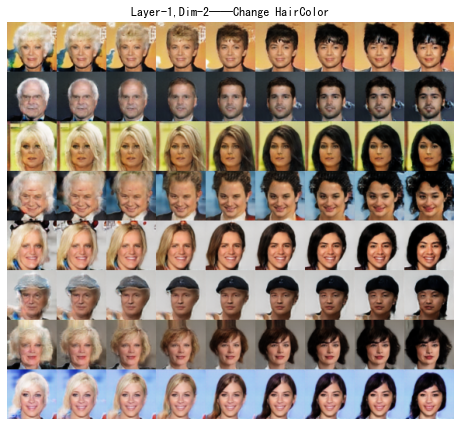

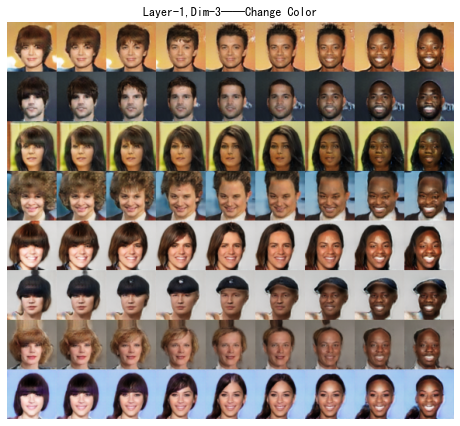

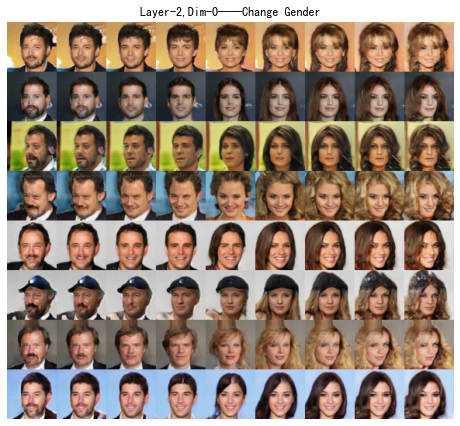

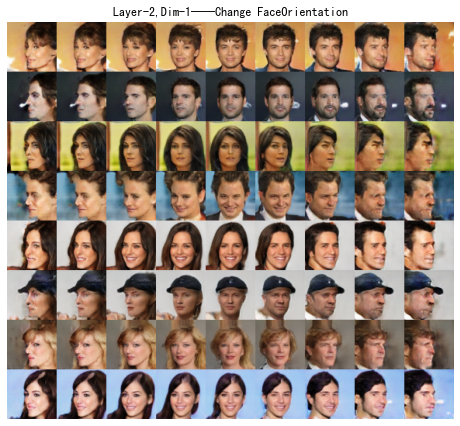

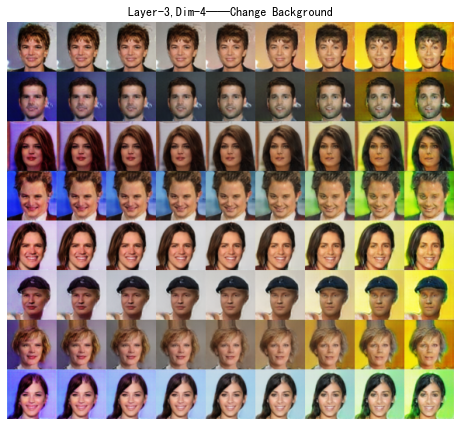

In [21]:
ckpt = './model/model.pt'
logdir = 'others'
ckpt = torch.load(ckpt, map_location="cpu")
g_ema = Generator(
    size=size,
    n_basis=n_basis,
    noise_dim=noise_dim,
    base_channels=base_channels,
    max_channels=max_channels,
).eval()
g_ema.load_state_dict(ckpt["g_ema"])
print("traversing:")
traverse_samples = 8
traverse_range = 4.0
intermediate_points = 9
truncation = 0.7

es, zs = g_ema.sample_latents(traverse_samples, truncation=truncation)

_, n_layers, n_dim = zs.shape

offsets = np.linspace(-traverse_range, traverse_range, intermediate_points)
for i_layer in range(n_layers):
    for i_dim in range(n_dim):
        print(f"  layer {i_layer} - dim {i_dim}")
        imgs = []
        for offset in offsets:
            _zs = zs.clone()
            _zs[:, i_layer, i_dim] = offset
            with torch.no_grad():
                img = g_ema((es, _zs)).cpu()
                img = torch.cat([_img for _img in img], dim=1)
            imgs.append(img)
        imgs = torch.cat(imgs, dim=2)

        imgs = (imgs.permute(1, 2, 0).numpy() * 127.5 + 127.5).astype(np.uint8)
        Image.fromarray(imgs).save(
            os.path.join(logdir, f"traverse_L{i_layer}_D{i_dim}.png")
        )
print("图片保存在others文件夹下面")  
print("-"*20)   
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L1_D5.png'))
plt.title("Layer-1,Dim-5——Change Hairstyle")
plt.axis('off')       
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L1_D2.png'))
plt.title("Layer-1,Dim-2——Change HairColor")
plt.axis('off')  
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L1_D3.png'))
plt.title("Layer-1,Dim-3——Change Color")
plt.axis('off')     
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L2_D0.png'))
plt.title("Layer-2,Dim-0——Change Gender")
plt.axis('off')     
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L2_D1.png'))
plt.title("Layer-2,Dim-1——Change FaceOrientation")
plt.axis('off')    
plt.figure(figsize=(8, 8))
plt.imshow(plt.imread('others/traverse_L3_D4.png'))
plt.title("Layer-3,Dim-4——Change Background")
plt.axis('off')
plt.show()

**全部图像都推理正确，并且图像显示清晰，都可以体现各个语义特征**

---
###  2.5 模型评估（在CUDA下进行相关的模型评估，评估测试的速度较快）

对测试集进行相关的评估工作，我采用的FID指标，该指标具体内容已经在上文提及到。FID使用预训练的**Inception**网络作为特征提取器，该网络经过大量图像数据的学习，能够提取出对图像内容有意义的特征。因此，FID能够反映图像生成模型生成的图像内容的质量。其中，FID值越小，表示生成模型生成的图像越多样，这是因为FID能够捕捉到生成图像分布与真实图像分布之间的细微差异，包括多样性方面的差异。同时，FID值越小也意味着生成图像的质量越好，因为FID能够反映图像内容的真实性和清晰度。

In [21]:
ckpt = './model/model.pt'
# num_samples = 1000
indices = list(range(1000))
ckpt = torch.load(ckpt, map_location="cpu")
g_ema = Generator(
    size=size,
    n_basis=n_basis,
    noise_dim=noise_dim,
    base_channels=base_channels,
    max_channels=max_channels,
).eval()
g_ema.load_state_dict(ckpt["g_ema"])
test_transfrom = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
])
test_dataset = Dataset(test_path, test_transfrom)
# subset = test_dataset.get_subset(indices)
compute_fid = get_fid_fn(test_dataset,device=device)
fid_score = compute_fid(generator=g_ema)
print("fid_score=",fid_score)

fid_score= 18.775347903576062


###  2.6 模型改进方向

我个人认为，模型的改进方向具有以下这几点：

1. 所提出的模型在生成图像的多样性仍然存在一定的缺点，这些归结于数据集中属性分布不均造成的，比如数据集中“秃头”的人脸照片比较少，所以生成图像中的具有秃头特征的图像较少。而为了解决这个问题，可以自建一个范围更广的人脸数据集。

2. 所提出的模型生成图像的效果质量还是不足，可以采用渐进式生长，从低分辨率开始训练，逐渐增加图像分辨率，改善生成效果。

3. 可以尝试使用经验回放的方式，将之前生成的图像样本存储并混合使用，丰富训练数据，防止模式崩溃。

---
## 3 基于扩散模型的人脸生成（由于目前扩散模型在人脸图像生成中也具有广泛的应用，所以下面将会尝试使用扩散模型进行相关的人脸生成任务）

---
### 3.1 导入相关包

In [22]:
from tqdm import tqdm
from torchvision import models
from packaging import version
import numpy as np
from scipy import linalg
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt
from torch.nn import functional as F
import json
from torch.autograd import Variable
from tqdm import trange
from scipy.stats import entropy
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import os
from torchvision.utils import save_image, make_grid
import math
import copy
import torch
from torch.nn import init
import random
from torch.utils.tensorboard import SummaryWriter

---
### 3.2 数据集处理
由于扩散模型所采用的数据集与GAN网络所有的数据集相同（CelebA数据集）

In [23]:
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')


def infinite_loader(data_loader):
    while True:
        for batch in data_loader:
            yield batch


class Dataset:
    def __init__(self, root, transform=None):
        self.root = root
        self.imgs = []
        for dir, _, fnames in sorted(os.walk(root, followlinks=True)):
            for fname in sorted(fnames):
                if fname.lower().endswith(IMG_EXTENSIONS):
                    self.imgs.append(os.path.join(dir, fname))

        self.transform = transform if transform is not None else lambda x: x

    def __getitem__(self, index):
        with open(self.imgs[index], 'rb') as f:
            img = Image.open(f)
            return self.transform(img.convert('RGB'))

    def __len__(self):
        return len(self.imgs)
    def get_subset(self, indices):
        subset = Dataset(self.root, self.transform)
        subset.imgs = [self.imgs[i] for i in indices]
        return subset

---
### 3.3 模型训练步骤

在该部分，我将会采用当前较火的Diffusion模型进行相关的图像生成。其中对于Diffusion模型中，较为经典的模型是DDPM（Denoising Diffusion Probabilistic Models）和它的改进版DDIM（Denoising Diffusion Implicit Models）。这两种经典的模型，在生成高质量图像方面具有显著的性能。下面我将会对这两种基本的模型做简单的描述。

- DDPM模型：它的工作步骤主要分为正向加噪和反向去噪的过程。
    1. 正向加噪：从真实数据分布开始，逐步添加噪声，使图像变得越来越模糊。这个过程由Markov链描述，即每一步的状态仅依赖于前一步的状态。其中数学表达式为：
    $$
    q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I)
    $$
    其中$\beta_t$是一个固定的常量。
    
    而大部分情况下，我们更需要的是$x_t$和$x_0$之间的关系。通过一定的数学推导公式，我们可以得出以下的公式：
    $$
        x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
    $$
    其中$\epsilon$为满足正态分布的噪声，$\bar{\alpha}_t = \alpha_t \alpha_{t-1} \cdots \alpha_1$, 其中$\alpha_t = 1 - \beta_t$
    
    2. 反向去噪：在训练阶段，学习如何从噪声图像一步步地去噪还原到原始图像。生成图像时，模型从纯噪声开始，逐步进行去噪，最终得到高质量的图像。其中的数学公式如下所示：
    $$
    p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_\theta(t) I)
    $$
    此式子同样可以表示为：
    $$
    P(x_{t-1} | x_t) = \mathcal{N} \left( \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon \right), \frac{(1 - \alpha_t)(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \right)
    $$
    因此所有的工作中，噪声值是无法确定的，只知道它是服从正态分布的，所以我们需要使用神经网络进行预测噪声。使用预测噪声的模型有很多，本次项目中采用的是`U-Net`模型，下面部分将会进行详细的介绍。
- DDIM模型：DDIM是对DDPM的一种改进，通过隐式的去噪过程来加速图像生成。其目标是在保持生成图像质量的前提下，加速生成过程。其中DDPM模型本身是一个马尔科夫链的过程，即前后时刻数据有非常紧密的绑定关系，无法进行跳跃预测。但是想要高质量的生成图片，就意味着`时间步长(T)`要取一个比较大的值，所以DDPM将会导致推理时间较长。因此DDIM模型在DDPM模型上进行了改进，采用了一种非马尔科夫链的方式，加快了推理速度。具体的数学公式如下所示：
$$
x_{\text{prev}} = \sqrt{\bar{\alpha}_{\text{prev}}} \left( \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_t}{\sqrt{\bar{\alpha}_t}} \right) + \sqrt{1 - \bar{\alpha}_{\text{prev}} - \sigma_t^2 \epsilon_t + \sigma^2 \epsilon}
$$
其中，$x_t$和$x_{prev}$可以相隔多个迭代步数

根据对DDPM和DDIM的分析，为了加快推理速度，我们最终使用了**DDIM**作为我们图像生成的模型。

#### 3.3.1 U-Net网络的搭建：该网络的输入不仅需要输入图像特征，还需要额外再输入一个时间特征t。

- 定义了上采样和下采样操作的别名。

In [24]:
class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x

- 时间向量嵌入：由于神经网络的参数在时间（噪声水平）上共享，作者使用正弦位置嵌入来编码$t$，灵感来自Transformer。对于批处理中的每一张图像，神经网络"知道"它在哪个特定时间步长（噪声水平）上运行。

In [25]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [26]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

- Attention模块

In [27]:
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

- ResNet块：定义U-Net模型的核心构建块。

In [28]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h

- 定义U-Net网络

In [29]:
class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

#### 3.3.2 正向加噪的过程：我们人为加一个符合正态分布的噪音$noise$，并且向U-Net网络中传递两个参数，一个是$x_t$，另外一个是$t$，并且我们利用`MSE`的损失函数进行相关的计算

In [30]:
def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    out = torch.gather(v, index=t, dim=0).float()
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        loss = F.mse_loss(self.model(x_t, t), noise, reduction='none')
        return loss

#### 3.3.3 反向去噪的采样过程，这块是DDPM的采样过程，在后续的实验中，我们验证了该方法的推理速度远远不如DDIM的推理速度

In [31]:
class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, img_size=32,
                 mean_type='eps', var_type='fixedlarge'):
        assert mean_type in ['xprev' 'xstart', 'epsilon']
        assert var_type in ['fixedlarge', 'fixedsmall']
        super().__init__()

        self.model = model
        self.T = T
        self.img_size = img_size
        self.mean_type = mean_type
        self.var_type = var_type

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_recip_alphas_bar', torch.sqrt(1. / alphas_bar))
        self.register_buffer(
            'sqrt_recipm1_alphas_bar', torch.sqrt(1. / alphas_bar - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.register_buffer(
            'posterior_var',
            self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        # below: log calculation clipped because the posterior variance is 0 at
        # the beginning of the diffusion chain
        self.register_buffer(
            'posterior_log_var_clipped',
            torch.log(
                torch.cat([self.posterior_var[1:2], self.posterior_var[1:]])))
        self.register_buffer(
            'posterior_mean_coef1',
            torch.sqrt(alphas_bar_prev) * self.betas / (1. - alphas_bar))
        self.register_buffer(
            'posterior_mean_coef2',
            torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def q_mean_variance(self, x_0, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior
        q(x_{t-1} | x_t, x_0)
        """
        assert x_0.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_log_var_clipped = extract(
            self.posterior_log_var_clipped, t, x_t.shape)
        return posterior_mean, posterior_log_var_clipped

    def predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_bar, t, x_t.shape) * eps
        )

    def predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            extract(
                1. / self.posterior_mean_coef1, t, x_t.shape) * xprev -
            extract(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t,
                x_t.shape) * x_t
        )

    def p_mean_variance(self, x_t, t):
        # below: only log_variance is used in the KL computations
        model_log_var = {
            # for fixedlarge, we set the initial (log-)variance like so to
            # get a better decoder log likelihood
            'fixedlarge': torch.log(torch.cat([self.posterior_var[1:2],
                                               self.betas[1:]])),
            'fixedsmall': self.posterior_log_var_clipped,
        }[self.var_type]
        model_log_var = extract(model_log_var, t, x_t.shape)

        # Mean parameterization
        if self.mean_type == 'xprev':       # the model predicts x_{t-1}
            x_prev = self.model(x_t, t)
            x_0 = self.predict_xstart_from_xprev(x_t, t, xprev=x_prev)
            model_mean = x_prev
        elif self.mean_type == 'xstart':    # the model predicts x_0
            x_0 = self.model(x_t, t)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        elif self.mean_type == 'epsilon':   # the model predicts epsilon
            eps = self.model(x_t, t)
            x_0 = self.predict_xstart_from_eps(x_t, t, eps=eps)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        else:
            raise NotImplementedError(self.mean_type)
        x_0 = torch.clip(x_0, -1., 1.)

        return model_mean, model_log_var

    def forward(self, x_T):
        """
        Algorithm 2.
        """
        x_t = x_T
        for time_step in reversed(range(self.T)):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            mean, log_var = self.p_mean_variance(x_t=x_t, t=t)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            x_t = mean + torch.exp(0.5 * log_var) * noise
        x_0 = x_t
        return torch.clip(x_0, -1, 1)

#### 3.3.4 DDIM的反向去噪的采样过程：通过输入一个高斯分布的图像($3 \times 64 \times 64$)，通过反向去噪的操作，得到对应的生成图像。

In [32]:
class DDIM(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, img_size=32, mean_type='eps', var_type='fixedlarge',
                 clip_denoised=True, ddim_eta=0.0):
        super(DDIM, self).__init__()
        self.model = model
        self.T = T
        self.img_size = img_size
        self.mean_type = mean_type
        self.var_type = var_type
        self.clip_denoised = clip_denoised
        self.ddim_eta = ddim_eta

        # beta_1,...,beta_T
        self.register_buffer('betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas  # alpha_1,...,alpha_T
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]  # 在最前面填充了一个1元素
        self.register_buffer('alphas_bar_prev_whole', F.pad(alphas_bar, [1, 0], value=1))
        self.register_buffer('sqrt_recip_alphas_bar', torch.sqrt(1. / alphas_bar))
        self.register_buffer('sqrt_recipm1_alphas_bar', torch.sqrt(1. / alphas_bar - 1))

        self.register_buffer('posterior_var', self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        # 猜测正态分布的方差不能为0,因为方差出现在系数的分母上
        self.register_buffer('posterior_log_var_clipped',
                             torch.log(torch.cat([self.posterior_var[1:2], self.posterior_var[1:]])))
        self.register_buffer('posterior_mean_coef1', torch.sqrt(alphas_bar_prev) * self.betas / (1. - alphas_bar))
        self.register_buffer('posterior_mean_coef2', torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar))

    # 根据x_t去计算x_0
    # torch.sqrt(1. / alphas_bar - 1)
    def predict_xstart_from_eps(self, x_t, t, eps):
        return (
                extract(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t -
                extract(self.sqrt_recipm1_alphas_bar, t, x_t.shape) * eps
        )

    def forward(self, x_T, sample_steps=10, process=False):
        assert self.T % sample_steps == 0
        x_t = x_T
        imgs = [torch.clip(x_t, -1, 1).cpu()]
        # [100,80,60,40,20]
        t_seq = torch.arange(sample_steps, self.T + 1, sample_steps)
        # [80,60,40,20,0]
        t_prev_seq = t_seq - sample_steps
        for i, j in tqdm(zip(reversed(list(t_seq)), reversed(list(t_prev_seq))), desc='Inference'):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * i
            prev_t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * j
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = extract(self.alphas_bar_prev_whole, t, x_t.shape)
            alpha_cumprod_t_prev = extract(self.alphas_bar_prev_whole, prev_t, x_t.shape)

            # 2. predict noise using model
            eps = self.model(x_t, t - 1)

            # 3. get the predicted x_0
            x_0 = self.predict_xstart_from_eps(x_t, t - 1, eps)
            if self.clip_denoised:
                x_0 = torch.clamp(x_0, min=-1., max=1.)

            # 4. compute variance:
            sigma_t = self.ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigma_t ** 2) * eps
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * x_0 + pred_dir_xt + sigma_t ** 2 * torch.randn_like(x_t)
            x_t = x_prev
            imgs.append(torch.clip(x_t, -1, 1).cpu())
        if process:
            imgs = torch.stack(imgs, dim=1)
            return torch.clip(x_t, -1, 1), imgs
        else:
            return torch.clip(x_t, -1, 1)

#### 3.3.5 设置扩散模型的超参数

In [40]:
CH = 128
CH_MULT = [1, 2, 2, 2]
ATT = [1]
NUM_RES_BLOCKS = 2
DROPOUT = 0.1
BETA_1 = 1e-4
BETA_T = 0.02
T = 1000
device = 'cuda:1'
MEAN_TYPE = 'epsilon'
VAR_TYPE = 'fixedlarge'
LR = 2e-4
GRAD_CLIP = 1
TOTAL_STEPS = 800000
IMG_SIZE = 64
WARMUP = 5000
BATCH_SIZE = 32
NUM_WORKERS = 4
EMA_DECAY = 0.9999
PARALLEL = False
LOGDIR = '../results/DDPM_CELEBA_EPS'
TENSOR_LOGDIR = '../results/tb_results/'
SAMPLE_SIZE = 32
SAMPLE_STEP = 1000
SAVE_STEP = 5000
EVAL_STEP = 0
NUM_IMAGES = 50000
FID_USE_TORCH = False
path = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/train/'
test_path = '../datasets/6687f1b43fcc3866cfed9592-650aa94c001b102e9e91d7a3/test/'


In [38]:
def ema(source, target, decay):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))
def infiniteloop(dataloader):
    while True:
        for x in iter(dataloader):
            yield x
def warmup_lr(step):
    return min(step, WARMUP) / WARMUP        

#### 3.3.6 模型展示（文字部分）

- Trainer

In [35]:
net_model = UNet(
        T=T, ch=CH, ch_mult=CH_MULT, attn=ATT,
        num_res_blocks=NUM_RES_BLOCKS, dropout=DROPOUT)
trainer = GaussianDiffusionTrainer(
        net_model, BETA_1, BETA_T, T)
print(trainer)

GaussianDiffusionTrainer(
  (model): UNet(
    (time_embedding): TimeEmbedding(
      (timembedding): Sequential(
        (0): Embedding(1000, 128)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): Swish()
        (3): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downblocks): ModuleList(
      (0-1): 2 x ResBlock(
        (block1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (temb_proj): Sequential(
          (0): Swish()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (block2): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stri

- Sample

In [36]:
net_model = UNet(
        T=T, ch=CH, ch_mult=CH_MULT, attn=ATT,
        num_res_blocks=NUM_RES_BLOCKS, dropout=DROPOUT)
DDIM_sampler = DDIM(net_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
print(DDIM_sampler)

DDIM(
  (model): UNet(
    (time_embedding): TimeEmbedding(
      (timembedding): Sequential(
        (0): Embedding(1000, 128)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): Swish()
        (3): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downblocks): ModuleList(
      (0-1): 2 x ResBlock(
        (block1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (temb_proj): Sequential(
          (0): Swish()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (block2): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): Swish()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

#### 3.3.6 训练过程（具体训练过程见trainDiffusion.py代码）

In [ ]:
device = torch.device(device) 
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
])
train_dataset = Dataset(path, transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last = True)
datalooper = infiniteloop(train_dataloader)
net_model = UNet(
        T=T, ch=CH, ch_mult=CH_MULT, attn=ATT,
        num_res_blocks=NUM_RES_BLOCKS, dropout=DROPOUT)

net_model.load_state_dict(ckpt['ema_model'])
ema_model = copy.deepcopy(net_model)
net_sampler = GaussianDiffusionSampler(
    net_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
ema_sampler = GaussianDiffusionSampler(
    ema_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
DDIM_sampler = DDIM(net_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
optim = torch.optim.Adam(net_model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=warmup_lr)
trainer = GaussianDiffusionTrainer(
        net_model, BETA_1, BETA_T, T).to(device)
device_ids = [0, 1, 2]
if PARALLEL:
    trainer = torch.nn.DataParallel(trainer, device_ids=device_ids)
    net_sampler = torch.nn.DataParallel(net_sampler, device_ids=device_ids)
    ema_sampler = torch.nn.DataParallel(ema_sampler, device_ids=device_ids)
x_T = torch.randn(SAMPLE_SIZE, 3, IMG_SIZE, IMG_SIZE)
x_T = x_T.to(device)
grid = (make_grid(next(iter(train_dataloader))[0][:SAMPLE_SIZE]) + 1) / 2
writer = SummaryWriter(TENSOR_LOGDIR)
writer.add_image('real_sample', grid)
writer.flush()
model_size = 0
# show model size
for param in net_model.parameters():
        model_size += param.data.nelement()
print('Model params: %.2f M' % (model_size / 1024 / 1024))
# start training
with trange(TOTAL_STEPS, dynamic_ncols=True) as pbar:
    for step in pbar:
        # train
        optim.zero_grad()
        x_0 = next(datalooper).to(device)
        loss = trainer(x_0).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            net_model.parameters(), GRAD_CLIP)
        optim.step()
        sched.step()
        ema(net_model, ema_model, EMA_DECAY)

        # log
        writer.add_scalar('loss', loss, step)
        pbar.set_postfix(loss='%.3f' % loss)

        # sample
        if SAMPLE_STEP > 0 and step % SAMPLE_STEP == 0:
            net_model.eval()
            with torch.no_grad():
                x_0 = DDIM_sampler(x_T)
                grid = (make_grid(x_0) + 1) / 2
                path = os.path.join(
                    LOGDIR, 'sample', '%d.png' % (step))
                os.makedirs(os.path.join(LOGDIR, 'sample'), exist_ok=True)
                save_image(grid, path)
                writer.add_image('sample', grid, step)
            net_model.train()

        # save
        if SAVE_STEP > 0 and step % SAVE_STEP == 0:
            ckpt = {
                'net_model': net_model.state_dict(),
                'ema_model': ema_model.state_dict(),
                'sched': sched.state_dict(),
                'optim': optim.state_dict(),
                'step': step,
                'x_T': x_T,
            }
            torch.save(ckpt, os.path.join(LOGDIR, 'ckpt.pt'))

writer.close()

具体训练时候的损失函数变化如下所示：
![](./others/loss.svg "Example1")

---
### 3.4 模型推理(由于在CPU上推理速度过慢，所以这里我主要放在Cuda上进行相关的推理)

Inference: 100it [00:22,  4.53it/s]


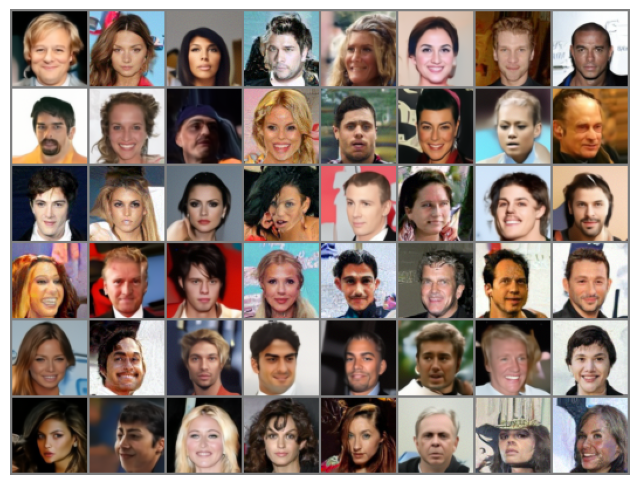

推理正确


In [43]:
device = "cuda:0"
x_T = torch.randn(48, 3, 64, 64)
x_T = x_T.to(device)
LOGDIR_inference = 'others'
net_model = UNet(
        T=T, ch=CH, ch_mult=CH_MULT, attn=ATT,
        num_res_blocks=NUM_RES_BLOCKS, dropout=DROPOUT)
ckpt = torch.load('./model/model_DDIM.pt')
net_model.load_state_dict(ckpt['ema_model'])
DDIM_sampler = DDIM(net_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
net_model.eval()
with torch.no_grad():
        x_0 = DDIM_sampler(x_T)
        grid = (make_grid(x_0) + 1) / 2
        path = os.path.join(LOGDIR_inference, 'output.png')
os.makedirs(os.path.join(LOGDIR_inference), exist_ok=True)
save_image(grid, path)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
print("推理正确")

---
### 3.5 生成采样的gif图(由于在CPU上生成速度过慢，所以这里我主要放在Cuda上进行相关的生成)

In [ ]:
device = "cuda:0"
x_T = torch.randn(48, 3, 64, 64)
x_T = x_T.to(device)
LOGDIR_inference = 'others'
net_model = UNet(
        T=T, ch=CH, ch_mult=CH_MULT, attn=ATT,
        num_res_blocks=NUM_RES_BLOCKS, dropout=DROPOUT)
ckpt = torch.load('model_DDIM.pt', map_location="cpu")
net_model.load_state_dict(ckpt['ema_model'])
DDIM_sampler = DDIM(net_model, BETA_1, BETA_T, T, IMG_SIZE,
    MEAN_TYPE, VAR_TYPE).to(device)
net_model.eval()
with torch.no_grad():
        x_0, generated_images = DDIM_sampler(x_T, process = True)
pil_images = [Image.fromarray(np.transpose((image[0].detach().cpu().numpy()* 127.5 + 127.5).astype(np.uint8), (1, 2, 0))) for image in generated_images]

# 保存为 GIF 动画
output_path = os.path.join(LOGDIR_inference, 'diffusion_process.gif')
pil_images[0].save(output_path, save_all=True, append_images=pil_images[1:], duration=50)

具体的gif图如下所示：
<div align="center">
    <img  src="./others/diffusion_process.gif" style =" width: 360px;height: auto;">
</div>

## 4 两个模型进行比较

通过这两次实验，我可以看出Diffusion模型相较于GAN模型来言，它的模型更大，因此它推理的时间也会相对较长，并且在训练的阶段中，GAN模型只需要4G的显存，而Diffusion模型在调小batch_size的时候，仍然需要接近8G的显存。下面可以针对这两个模型进行相关的总结和分析：
1. **GAN模型**：

    **优点**：
        1. 生成速度快：一旦训练完成，生成图像的速度非常快，因为仅需要通过生成器进行一次前向传播。
        2. 高质量图像：在训练充分的情况下，GAN可以生成高分辨率、细节丰富的图像，图像质量通常较高。
        3. 多样性：能生成多样化的图像，并能够通过调整输入噪声向量生成不同的图像。
        4. 训练灵活性：可以与多种损失函数结合，适应不同的应用场景，比如WGAN（Wasserstein GAN）改善了传统GAN的训练稳定性。
    
    **缺点**：
        1. 训练不稳定：训练过程中可能会出现模式崩溃（mode collapse），即生成器生成的图像缺乏多样性。
        2. 训练复杂：需要同时训练生成器和判别器，训练过程需要精细的超参数调整和技巧，如学习率调整、网络架构选择等。
2. **Diffusion模型**：

    **优点**：
        1. 训练稳定：训练过程通常更稳定，不易出现模式崩溃问题，因为其基于逐步添加噪声的反向过程。
        2. 理论基础：有良好的理论基础和解释，基于马尔可夫链和变分推断，提供了生成图像的概率解释。
        3. 高质量生成：可以生成高质量的图像，尤其在高分辨率图像生成和细节保留方面表现优异。
        4. 训练灵活性：可以与多种损失函数结合，适应不同的应用场景，比如WGAN（Wasserstein GAN）改善了传统GAN的训练稳定性。

    **缺点**：
        1. 生成速度慢：生成图像需要逐步去噪过程，通常需要多步迭代，因此生成速度较慢。
        2. 训练时间长：训练过程可能需要较长时间，因为每个训练步骤都涉及多个去噪过程。
        3. 推理速度慢：相较于GAN网络而言，GAN模型更大，推理速度也更慢。

## 5 实战心得

我认为人脸生成的此次实战中，有许多可以探索和研究的地方。

人脸生成任务在计算机视觉和图像处理领域具有重要意义。通过生成逼真的人脸图像，可以在多个应用场景中提供支持，如娱乐、艺术创作、虚拟现实、身份验证和隐私保护等。在本小节中，我将会分享我通过构建可控制生成图像语义特征的GAN网络与Diffusion网络进行相关的人脸生成的心得体会：

1. 数据集分析：
    - 本次我采用的是CelebA的人脸数据集，该数据集包含了202,599张图片。在本次实验中，我们裁剪为$64 \times 64$的大小图片。
    - 由于是第一次接触图像生成的任务，对于划分训练集、测试集、验证集的方式有点不太清晰。之后通过阅读了相关人脸生成的文献，借鉴了他们相关的划分方法，我们最终将训练集视作整个数据集，测试集为从训练集中随机挑选出50k张图片。
    - 额外采用了图像增强的方式来提高生成模型的鲁棒性。图像增强操作包括：随机改变亮度、对比度、随机平移、随机裁剪等。

2. 模型搭建：
    - GAN模型：为了去控制生成图像的语义特征，我们在生成器的每一生成层中，都嵌入一个子空间，通过正交分解和无监督学习的方法，来控制每一生成层的主要语义特征。而对于鉴别器的架构，就与一些经典的GAN模型相同。损失函数采用了`hinge loss`。
    - Diffusion模型：本次实验采用的是DDIM的网络模型。在使用DDIM模型之前，我个人已经尝试采用DDPM模型进行对应的人脸生成任务，但是推理的效果极其之慢，所以后面采用了DDIM的模型进行相关的推理，推理速度会比DDPM模型速度快接近5倍。

3. 评价指标选择：
    - 由于个人是第一次接触图像生成的任务，对于如何评估模型的好坏，我一开始只想到通过肉眼观察的方式，来观察生成的效果，而对于如何评判生成效果的量化指标，并没有十分的了解。所以通过调研了相关的文献，发现可以通过**FID**的指标进行评估生成模型的效果。

4. 推理和测试：
    - 在完成网络模型训练之后，我们需要进行推理和测试来品谷模型的性能和准确性。

总而言之：在整个项目过程中，及时记录实验的参数设置、训练结果、测试结果等信息，以便后续的复现和参考。本次项目中，我通过改进现有的GAN模型和重新复现经典的扩散模型（DDIM）来去实现对应的人脸生成。而通过本次项目实战中，我通过比对了这两个模型的生成效果，我发现GAN适用于需要高多样性和细节丰富的场景，而Diffusion模型适用于需要高分辨率和稳定生成的场景。在最终生成效果可以看出，针对于Diffusion模型，它的超参数设置和优化需要深入的实验和调优，在实际应用中，具有一定的使用门槛。本项目中，我看到了GAN和Diffusion模型在生成对抗网络领域带来了显著的进步，未来可以通过结合两者的优势，进一步推动生成模型的发展和应用。

## 6 不足之处

我认为我本次项目仍然存在以下不足之处：

1. 针对于提出的可以控制生成图像特征的GAN网络，其中特征向量分解操作在每一层进行会增加计算复杂度，尤其是在高维特征空间中，计算开销可能非常高。

2. 采用的GAN网络中，特征向量分解的效果高度依赖于特征空间的性质和分布，可能在某些情况下无法有效捕捉特征。

3. 采用的diffusion模型，不能像GAN网络一样具有控制生成图像特征的能力

## 7 未来展望

1. 改进传统的diffusion模型，使其也具有控制生成图像特征的能力。

2. 考虑多模态生成，例如在不同情绪、年龄、性别和姿态下生成不同的人脸。

3. 提供交互式工具（开发网站或者APP应用），投入到市场，使用户可以方便地调整和定制生成的人脸图像。

4. 在以后的项目开发过程中，我应该要多去使用国内的框架，比如Paddle和MindSpore框架，熟悉其中的框架和API函数的用法。我也相信在国内科研人员的帮助下，这些国内框架将会有快速的发展，会与Pytorch或者是tensflow齐头并进。